In [1]:
import os
import urllib.request
import pickle
import numpy as np
import pandas as pd
import cv2

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

In [2]:
train_dir = './train/'

In [3]:
image_size = 224
# image_size = 100 # FIXME

In [4]:
def preprocess_image(path):
    img = cv2.imread(path)
    if img is None:
        return np.zeros((1, depth, image_size, image_size))
    img = img[:, :, [2, 1, 0]]

    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    img = img[yy: yy + short_edge, xx: xx + short_edge]

    img = cv2.resize(img, (image_size, image_size))
    img -= 117
#     return img.reshape((image_size*image_size*depth)).astype(np.float32)
    return img

In [5]:
train_dataset = []
train_labels = []

labels_dirs = [f for f in os.listdir(train_dir) if os.path.isdir(train_dir + f)]
labels_dirs = sorted(labels_dirs)
print('Labels directories = {}'.format(labels_dirs))

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels_dirs)

for label in labels_dirs:
    subdir = train_dir + label + '/'
    encoded_label = label_encoder.transform([label])
    
    files = [f for f in os.listdir(subdir) if os.path.isfile(subdir + f) and os.path.splitext(f)[1] == '.jpg']
    
    for i, image_file in enumerate(files):
        img_path = subdir + image_file
        train_labels.append(encoded_label)
        processed_img = preprocess_image(img_path)
        train_dataset.append(processed_img)
        if (i % 100) == 0:
            print('{0}: {1} of {2}'.format(label, i, len(files)))

train_dataset = np.array(train_dataset)
train_labels = np.array(train_labels)

print('X.shape: ', train_dataset.shape)
print('Y.shape: ', train_labels.shape)

Labels directories = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ALB: 0 of 1719
ALB: 100 of 1719
ALB: 200 of 1719
ALB: 300 of 1719
ALB: 400 of 1719
ALB: 500 of 1719
ALB: 600 of 1719
ALB: 700 of 1719
ALB: 800 of 1719
ALB: 900 of 1719
ALB: 1000 of 1719
ALB: 1100 of 1719
ALB: 1200 of 1719
ALB: 1300 of 1719
ALB: 1400 of 1719
ALB: 1500 of 1719
ALB: 1600 of 1719
ALB: 1700 of 1719
BET: 0 of 200
BET: 100 of 200
DOL: 0 of 117
DOL: 100 of 117
LAG: 0 of 67
NoF: 0 of 465
NoF: 100 of 465
NoF: 200 of 465
NoF: 300 of 465
NoF: 400 of 465
OTHER: 0 of 299
OTHER: 100 of 299
OTHER: 200 of 299
SHARK: 0 of 176
SHARK: 100 of 176
YFT: 0 of 734
YFT: 100 of 734
YFT: 200 of 734
YFT: 300 of 734
YFT: 400 of 734
YFT: 500 of 734
YFT: 600 of 734
YFT: 700 of 734
X.shape:  (3777, 224, 224, 3)
Y.shape:  (3777, 1)


In [47]:
# TODO load
# with open('train_dataset.pkl', 'wb') as output:
#     pickle.dump(train_dataset, output, pickle.HIGHEST_PROTOCOL)
# with open('train_labels.pkl', 'wb') as output:
#     pickle.dump(train_labels, output, pickle.HIGHEST_PROTOCOL)

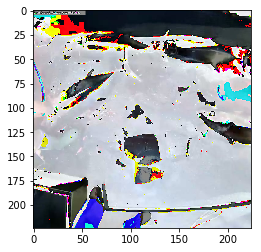

In [6]:
imshow(train_dataset[0])

In [7]:
num_labels = len(labels_dirs)
print('There are {} labels'.format(num_labels))

There are 8 labels


In [8]:
# print(train_labels[1700:1800, 0])
# train_labels = np.reshape(train_labels, train_labels.shape[0])
# print('Y.shape', train_labels.shape)
# print(train_labels[1700:1800])
# reformat labels
# 
# One-shot encoding of labels
train_labels = (np.arange(num_labels) == train_labels[:,None]).astype(np.float32)

In [9]:
# One more reshape
train_labels = train_labels.reshape(train_labels.shape[0], train_labels.shape[2])
train_labels.shape

(3777, 8)

In [10]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense


Using TensorFlow backend.


In [11]:
img_in = Input(shape=(image_size, image_size, 3), name='img_in')
type_in = Input(shape=(num_labels,), name='type_in')

x = Convolution2D(8, 3, 3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

type_out = Dense(num_labels, name='type_out')(x)

model = Model(input=[img_in], output=[type_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 16)        0         
__________

/opt/conda/lib/python3.6/site-packages/Keras-2.0.0-py3.6.egg/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`
  '` call to the Keras 2 API: ' + signature)
/opt/conda/lib/python3.6/site-packages/Keras-2.0.0-py3.6.egg/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
  '` call to the Keras 2 API: ' + signature)
/opt/conda/lib/python3.6/site-packages/Keras-2.0.0-py3.6.egg/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  '` call to the Keras 2 API: ' + signature)
/opt/conda/lib/python3.6/site-packages/Keras-2.0.0-py3.6.egg/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [12]:
import os
from keras import callbacks

model_path = os.path.expanduser('~/best_model.hdf5')

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [13]:
model.fit(train_dataset, train_labels, nb_epoch=100, validation_split=.2, callbacks=callbacks_list)

/opt/conda/lib/python3.6/site-packages/Keras-2.0.0-py3.6.egg/keras/engine/training.py:1393: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3021 samples, validate on 756 samples
Epoch 1/100
3021/3021 [==============================] - 83s - loss: 237793.0889 - val_loss: 183.7431
Epoch 2/100
3021/3021 [==============================] - 84s - loss: 182.0144 - val_loss: 105.8935
Epoch 3/100
3021/3021 [==============================] - 84s - loss: 86.0629 - val_loss: 66.0742
Epoch 4/100
3021/3021 [==============================] - 82s - loss: 50.5310 - val_loss: 54.5906
Epoch 5/100
3021/3021 [==============================] - 80s - loss: 34.4769 - val_loss: 44.6035
Epoch 6/100
3021/3021 [==============================] - 76s - loss: 25.5510 - val_loss: 41.2561
Epoch 7/100
3021/3021 [==============================] - 77s - loss: 20.9553 - val_loss: 38.5846
Epoch 8/100
3021/3021 [==============================] - 76s - loss: 17.5043 - val_loss: 36.0566
Epoch 9/100
3021/3021 [==============================] - 77s - loss: 15.1509 - val_loss: 34.2630
Epoch 10/100
3021/3021 [==============================] - 77s - loss: 13.

KeyboardInterrupt: 

In [59]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
        / predictions.shape[0])

In [66]:
model = load_model(model_path)

P = model.predict(train_dataset)
#predict outputs nested arrays so we need to reshape to plot.
# P = P.reshape((P.shape[0],)) 

# pd.DataFrame({'predicted':P, 'actual':train_labels[:500]}).plot()

In [67]:
accuracy(P, train_labels)
# print(np.argmax(P, 1))
# print(train_labels[1700:1800])

43.42070426264231